In [67]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import image
from scipy.spatial.transform import Rotation
from matplotlib.animation import FuncAnimation

элементы группы SO(3) и преобразования поворотов с анимацией движения
функции операторов реализованы через запрос по словарю из функций соответствующих преобразований

Углы пворота различают на углы Эйлера и Тейта - Брайана, которые различаются последовательностью поворотов через углы Эйлера это по вороты в двух осях, а Тейта - Брайана через последовательные повороты вокруг всех осей тоже справедливо и для поворотов через кватернионы реализуемые через произведение поворотов в соответствующих осях их произведением.
реализуем по 6 поворотов Любое внешнее вращение эквивалентно внутреннему вращению на те же углы, но с обратным порядком элементарных вращений, и наоборот. Например, внутренние вращения x-y'-z″ на углы α , β , γ эквивалентны внешним вращениям zyx на углы γ , β , α ..
ref:
https://en.wikipedia.org/wiki/Davenport_chained_rotations
https://en.wikipedia.org/wiki/Euler_angles

вращения задаются следующими наборами поворотов вокруг соответствующих осей:

$Euler$ $angles:$ $(z-x-z, x-y-x, y-z-y, z-y-z, x-z-x, y-x-y)$

$Tait–Bryan$ $angles:$ $(x-y-z, y-z-x, z-x-y, x-z-y, z-y-x, y-x-z)$

Повороты это ортогональное преобразование, а значит $A^{-1} = A^{T}$ обратные операторы поворотов

In [74]:
class SO3:
    
    """Элементы группы поворотов"""
    def R_x(angl):
        """Определение матриц поворота вокруг оси х"""
        Rx = np.array([[1,            0,             0],
                       [0, np.cos(angl), -np.sin(angl)],
                       [0, np.sin(angl),  np.cos(angl)]])
        return Rx

    def R_y(angl):
        """Определение матриц поворота вокруг оси х"""
        Ry = np.array([[ np.cos(angl), 0, np.sin(angl)],
                       [ 0,            1,            0],
                       [-np.sin(angl), 0, np.cos(angl)]])
        return Ry

    def R_z(angl):
        """Определение матриц поворота вокруг оси х"""
        Rz = np.array([[np.cos(angl), -np.sin(angl), 0],
                       [np.sin(angl),  np.cos(angl), 0],
                       [           0,             0, 1]])
        return Rz

    def quaternion_product(q, p):
        """Определение произведения кватернионов"""
        q_rez = np.array([q[0]*p[0]-q[1]*p[1]-q[2]*p[2]-q[3]*p[3],
                          q[0]*p[1]+q[1]*p[0]+q[2]*p[3]-q[3]*p[2],
                          q[0]*p[2]-q[1]*p[3]+q[2]*p[0]+q[3]*p[1],
                          q[0]*p[3]+q[1]*p[2]-q[2]*p[1]+q[3]*p[0]])
        return q_rez
    
    """Определение кватернионов для поворота вокруг каждой из орт"""
    def q_1(angl):
        return np.array([np.cos(angl/2), np.sin(angl/2), 0, 0])
    
    def q_2(angl):
        return np.array([np.cos(angl/2), 0, np.sin(angl/2), 0])
    
    def q_3(angl):
        return np.array([np.cos(angl/2), 0, 0, np.sin(angl/2)])

    """Словарь функций поворота для матриц поворота и кватернионов"""
    matrix = {"x": R_x,
             "y": R_y,
             "z": R_z}
    
    quat = {"x": q_1,
            "y": q_2,
            "z": q_3}

In [103]:
class rotation(SO3):
    
    def for_matrixs(initial_vector, angles, type_of_rotation ="default", 
              conversion_type ="default", sequence_of_rotation ="default"):
    
        """Функция расчета поворотов через матрицы поворотов и углы Эйлера, Тейта - Брайана
        запись поворота прямая алгебраическая означает что такая запись xyz комбинирует операторы поворота в той же 
        последовательности, тоесть R_x(alpha)*R_y(beta)*R_z(gamma)*v, где v вектор. 
        Углы задаются последовательностью которой комбинируется поворот alpha, beta, gamma задается массивом с таким порядком.
        type_of_rotation - внешний или внутренний поворот (extrinsic/intrinsic)
        conversion_type - прямое или обратное преобразование (direct/inverse)
        sequence_of_rotation - последовательность операторов поворота "xyz"
        """

        """Простая проверка"""
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")
        elif (conversion_type == "default"):
            raise ValueError("error - прямое/обратное перобразование на задано")
        elif (type_of_rotation == "default"):
            raise ValueError("error - тип поворота не задан")


        """приведение строк к нужному типу"""
        sequence_of_rotation = sequence_of_rotation.casefold()
        type_of_rotation = type_of_rotation.lower()
        conversion_type = conversion_type.lower()

        """Вычисление преобразований"""
        rez_vector = initial_vector

        if (type_of_rotation == "extrinsic"):

            if (conversion_type == "direct"):

                angle_order = 0

                for order in sequence_of_rotation[::-1]:
                    rez_vector = (SO3.matrix[order](angles[int(len(angles)-1)-angle_order])).dot(rez_vector)  
                    angle_order += 1
                return rez_vector

            elif(conversion_type == "inverse"):

                angle_order = 0       
                for order in sequence_of_rotation:
                    rez_vector = ((SO3.matrix[order](angles[angle_order])).T).dot(rez_vector)  
                    angle_order += 1
                return rez_vector

        elif (type_of_rotation == "intrinsic"):

            if (conversion_type == "direct"):

                angle_order = 0       
                for order in sequence_of_rotation:
                    rez_vector = (SO3.matrix[order](angles[angle_order])).dot(rez_vector)  
                    angle_order += 1
                return rez_vector

            elif(conversion_type == "inverse"):

                angle_order = 0       
                for order in sequence_of_rotation[::-1]:
                    rez_vector = ((SO3.matrix[order](angles[int(len(angles)-1)-angle_order])).T).dot(rez_vector)  
                    angle_order += 1
                return rez_vector
            
    def for_quaternions(initial_vector, angles,
              conversion_type ="default", sequence_of_rotation ="default"):

        """Простая проверка"""
        if (sequence_of_rotation =="default"):
            raise ValueError("error - последовательность поворотов не задана")
        elif (conversion_type == "default"):
            raise ValueError("error - прямое/обратное перобразование на задано")

        """приведение строк к нужному типу"""
        sequence_of_rotation = sequence_of_rotation.casefold()
        conversion_type = conversion_type.lower()

        """Вычисление преобразований"""
        rez_vector = initial_vector

        angle_order = 0 
        quat_array = np.zeros((len(sequence_of_rotation), 4))

        for order in sequence_of_rotation:
            quat_array[angle_order, :] = SO3.quat[order](angles[angle_order])       
            angle_order += 1
        
#         quat_array[angle_order, :] = [SO3.quat[order](angles[angle_order]) for order in sequence_of_rotation]      
        
        """Произведение кватернионов как результирующий поворот"""
        q = SO3.quaternion_product(quat_array[0, :], quat_array[1, :])
        for i in range(1, len(sequence_of_rotation)-1):    
            q = SO3.quaternion_product(q, quat_array[i+1, :])

        """ матрица направляющих косинусов через коэфициенты кватерниона"""
        QR =  np.array([[q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2, 2*(q[1]*q[2] - q[0]*q[3]), 2*(q[0]*q[2] + q[1]*q[3])],
                        [2*(q[0]*q[3] + q[1]*q[2]), q[0]**2 - q[1]**2 + q[2]**2 - q[3]**2, 2*(q[2]*q[3] - q[0]*q[1])],
                        [2*(q[1]*q[3] - q[0]*q[2]), 2*(q[0]*q[1] + q[2]*q[3]), q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2]])

        if (conversion_type == "direct"):
            rez_vector = QR.dot(initial_vector)
        elif (conversion_type == "inverse"):
            rez_vector = (QR.T).dot(initial_vector)

        return rez_vector


In [104]:
"""Еденичный вектор x"""
x = np.array([[1],
              [0],
              [0]])
"""Еденичный вектор z""" 
z = np.array([[0],
              [0],
              [1]])

проверка

In [105]:
rotation.for_quaternions(x, np.array([3, 2, 1]), "direct", "xyz")

array([[-0.2248451 ],
       [-0.76371834],
       [ 0.60512725]])

In [106]:
chek_v = Rotation.from_euler('zyx', [1, 2, 3]).apply(np.array([1, 0, 0]))
chek_v

array([-0.2248451 , -0.76371834,  0.60512725])

In [107]:
"""колличество итераций"""
N = 1000 
"""время"""
t = np.linspace(0, 30, N)
"""частота"""
w = 0.25
"""амплитуда"""
A = 1/4
"""углы параметризированные временем (качка)"""
phi_arr = A/2*np.sin(2*np.pi*w/5*t)
tet_arr = A/4*np.cos(2*np.pi*w/2.5*t)
psi_arr = A*np.sin(2*np.pi*w*t)

<IPython.core.display.Javascript object>


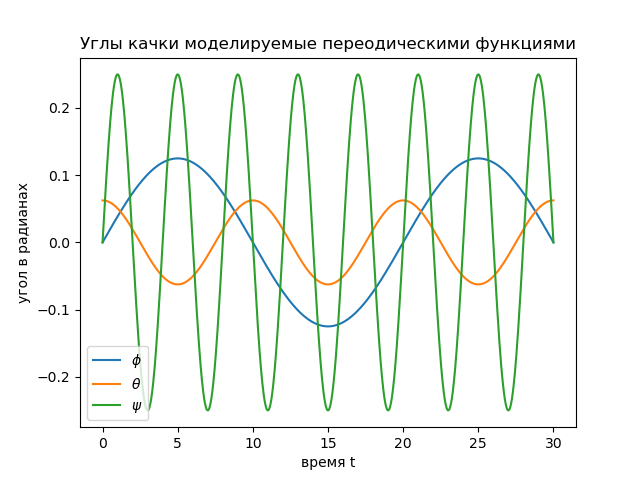

In [108]:
plt.plot(t, phi_arr, label=r'$\phi$')
plt.plot(t, tet_arr, label=r'$\theta$')
plt.plot(t, psi_arr, label=r'$\psi$')
plt.legend()
plt.xlabel('время t')
plt.ylabel('угол в радианах')
plt.title('Углы качки моделируемые переодическими функциями')
plt.show()

In [114]:
"""моделирование возмущенного движения параметризованными углами"""
"""входной вектор"""
r = np.array([[0],
              [0],
              [1]])
"""определение результирующего вектора и углов"""
rez_vect = np.zeros((3, N))
# rez_vect[:, 0] = r[:, 0]
"""расчет всех поворотов как действия оператора во времени"""
for i in range(0, N):
    rez_vect[:, i] = rotation.for_matrixs(r, np.array([phi_arr[i], tet_arr[i], psi_arr[i]]),"extrinsic","direct","zyx")[:,0]

<IPython.core.display.Javascript object>


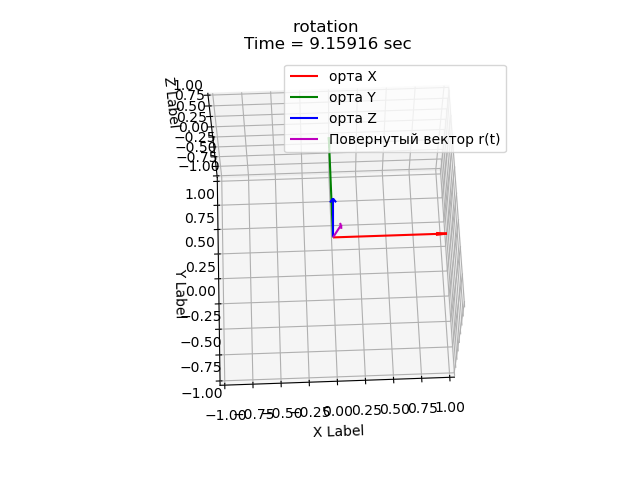

In [115]:
"""анимация"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.clear()
    ax.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1, label=r'орта X')
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1, label=r'орта Y')
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', arrow_length_ratio=0.1, label=r'орта Z')
    ax.quiver(0, 0, 0, rez_vect[0, frame], rez_vect[1, frame], rez_vect[2, frame],
              color='m', arrow_length_ratio=0.1, label=r'Повернутый вектор r(t)')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    
    ax.set_title('rotation \nTime = ' + str((float('{:.5f}'.format(frame*(t[1]-t[0]))))) + ' sec')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.legend()
ani = FuncAnimation(fig, update, frames=N, interval=5)
plt.show()